# Journal 2022-09-27
Going through [Differentiable Programming with JAX](https://ericmjl.github.io/dl-workshop/index.html) Tutorial

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ipywidgets import interact, FloatSlider, fixed
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from journal_20220927 import (
    LinearModel, NoisyMeasurement, mse, LogisticModel
)

In [4]:
generator_model = NoisyMeasurement(model=LinearModel())

In [5]:
x = np.linspace(-5., 5., 100)
y = generator_model(x)

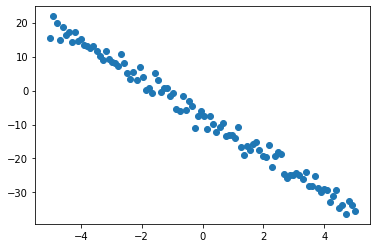

In [6]:
fig, ax = plt.subplots()
_  = ax.scatter(x, y)

In [7]:
class Plotter:
    def __init__(self, x, y, model, loss):
        self.x = x
        self.y = y
        self.model = model
        self.loss = loss
        
    def plot(self, w, b):
        fig, ax = plt.subplots()
        _  = ax.scatter(self.x, self.y)
        y_pred = self.model(params={'w': w, 'b': b})(self.x)
        _ = ax.plot(self.x, y_pred, c='r')
        _ = ax.set_title(f'Loss: {self.loss(y, y_pred):0.2f}')

In [8]:
plotter_linear = Plotter(x, y, LinearModel, mse)

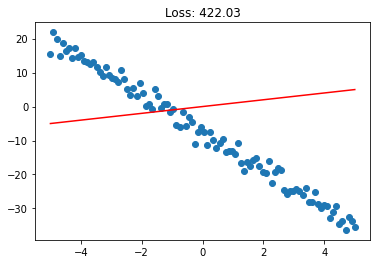

In [9]:
plotter_linear.plot(1., 0.)

In [10]:
_ = interact(
    plotter_linear.plot, 
    w=FloatSlider(value=0., min=-10, max=10.),
    b=FloatSlider(value=0., min=-10, max=10.),
)

interactive(children=(FloatSlider(value=0.0, description='w', max=10.0, min=-10.0), FloatSlider(value=0.0, des…

In [11]:
generator_model.params

{'w': -5.349637851536673, 'b': -7.526005274996404}

Use JAX autodiff to get gradient of loss function and optimize parameters 

In [12]:
@jax.jit
def loss(params, x, y):
    return mse(y, LinearModel(params)(x))

In [13]:
jax.grad(loss)({'w': 1., 'b': 0.}, x, y)

{'b': DeviceArray(15.26967, dtype=float32, weak_type=True),
 'w': DeviceArray(110.67938, dtype=float32, weak_type=True)}

Fit w: -5.50  (Actual: -5.35)
Fit b: -7.55  (Actual: -7.53)


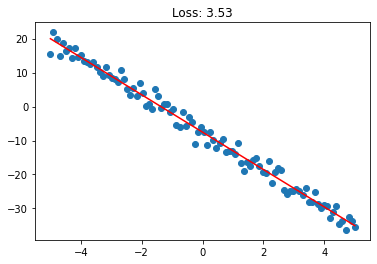

In [14]:
params = {'w': 1., 'b': 0.}
lr = 0.1  # Learning Rate
losses = []
for i in range(20):
    loss_val, d_params = jax.value_and_grad(loss)(params, x, y)
    losses.append(loss_val)
    params = {k: v - lr*d_params[k] for k, v in params.items()}
plotter_linear.plot(params['w'], params['b'])
print(f'Fit w: {params["w"]:.2f}  (Actual: {generator_model.params["w"]:.2f})')
print(f'Fit b: {params["b"]:.2f}  (Actual: {generator_model.params["b"]:.2f})')

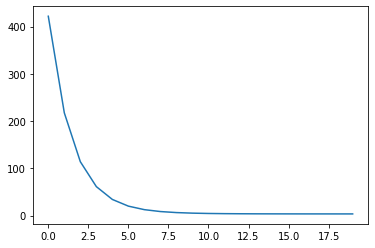

In [15]:
_ = plt.plot(losses)

Play with CVXPY 

In [16]:
import cvxpy as cp
from cvxpylayers.jax import CvxpyLayer 

In [17]:
theta = cp.Variable(2)
objective = cp.Minimize(cp.norm2(y - (theta[0]*x + theta[1])))
problem = cp.Problem(objective)
problem.solve()

18.75417600582522

In [18]:
theta.value

array([-5.50926313, -7.6348353 ])

In [19]:
problem.value**2/100  # min MSE

3.5171911765747037

## Logistic Regression

In [20]:
logistic_generator_model = LogisticModel(
    model=NoisyMeasurement(
        params={'loc': 0., 'scale': 0.5},
        model=LinearModel({'w': 2., 'b': 1}))
)

In [21]:
y_logistic = logistic_generator_model(x)

In [22]:
logistic_pred_model = LogisticModel(LinearModel())

In [23]:
def cross_entropy(y_true, y_pred):
    return -jnp.sum(
        y_true * jnp.log(y_pred) 
        + (1 - y_true) * jnp.log(1 - y_pred)
    )

In [24]:
plotter_logistic = Plotter(x, y_logistic, LogisticModel, cross_entropy)

In [25]:
_ = interact(
    plotter_logistic.plot, 
    w=FloatSlider(value=0., min=-10, max=10.),
    b=FloatSlider(value=0., min=-10, max=10.),
)

interactive(children=(FloatSlider(value=0.0, description='w', max=10.0, min=-10.0), FloatSlider(value=0.0, des…

In [26]:
def loss_ce(params, x, y):
    return cross_entropy(y, LogisticModel(params)(x))

Fit w: 1.88  (Actual: 2.00)
Fit b: 0.84  (Actual: 1.00)


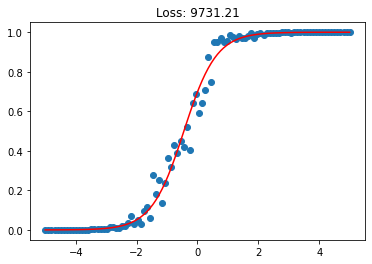

In [27]:
params = {'w': 1., 'b': 0.}
lr = 0.1  # Learning Rate
losses = []
for i in range(20):
    loss_val, d_params = jax.value_and_grad(loss_ce)(params, x, y_logistic)
    losses.append(loss_val)
    params = {k: v - lr*d_params[k] for k, v in params.items()}
plotter_logistic.plot(params['w'], params['b'])
print(f'Fit w: {params["w"]:.2f}  (Actual: {logistic_generator_model.params["w"]:.2f})')
print(f'Fit b: {params["b"]:.2f}  (Actual: {logistic_generator_model.params["b"]:.2f})')

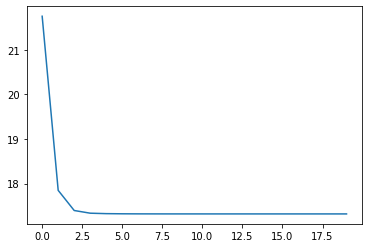

In [28]:
_ = plt.plot(losses)

In [29]:
logistic_generator_model.params

{'w': 2.0, 'b': 1}